In [29]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Path to dataset (Kaggle version)
dataset_path = '/kaggle/input/skyview-an-aerial-landscape-dataset/Aerial_Landscapes'

# Load all images from each class, report unreadable images
def load_and_split_by_class(dataset_path, image_size=(224, 224), train_ratio=0.8):
    X_train, y_train, X_test, y_test = [], [], [], []

    for label in sorted(os.listdir(dataset_path)):
        class_dir = os.path.join(dataset_path, label)
        if not os.path.isdir(class_dir):
            continue
        files = sorted(os.listdir(class_dir))
        images = []
        failed = 0
        for file_name in files:
            file_path = os.path.join(class_dir, file_name)
            img = cv2.imread(file_path)
            if img is None:
                failed += 1
                continue
            img = cv2.resize(img, image_size)
            images.append(img)

        print(f" Class '{label}': {len(images)} images loaded, {failed} failed")
        images = shuffle(images, random_state=42)
        split_idx = int(len(images) * train_ratio)
        X_train.extend(images[:split_idx])
        y_train.extend([label] * split_idx)
        X_test.extend(images[split_idx:])
        y_test.extend([label] * (len(images) - split_idx))

    return shuffle(np.array(X_train), np.array(y_train), random_state=42), shuffle(np.array(X_test), np.array(y_test), random_state=42)

(X_train, y_train), (X_test, y_test) = load_and_split_by_class(dataset_path)

le = LabelEncoder()
y_train_enc = to_categorical(le.fit_transform(y_train))
y_test_enc = to_categorical(le.transform(y_test))
class_names = le.classes_.tolist()

print("Each class split 80/20 successfully. Classes:", class_names)

 Class 'Agriculture': 800 images loaded, 0 failed
 Class 'Airport': 800 images loaded, 0 failed
 Class 'Beach': 800 images loaded, 0 failed
 Class 'City': 800 images loaded, 0 failed
 Class 'Desert': 800 images loaded, 0 failed
 Class 'Forest': 800 images loaded, 0 failed
 Class 'Grassland': 800 images loaded, 0 failed
 Class 'Highway': 800 images loaded, 0 failed
 Class 'Lake': 800 images loaded, 0 failed
 Class 'Mountain': 800 images loaded, 0 failed
 Class 'Parking': 800 images loaded, 0 failed
 Class 'Port': 800 images loaded, 0 failed
 Class 'Railway': 800 images loaded, 0 failed
 Class 'Residential': 800 images loaded, 0 failed
 Class 'River': 800 images loaded, 0 failed
Each class split 80/20 successfully. Classes: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.15,
                               width_shift_range=0.1, height_shift_range=0.1,
                               horizontal_flip=True)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow(X_train, y_train_enc, batch_size=32)
test_data = test_gen.flow(X_test, y_test_enc, batch_size=32, shuffle=False)


In [19]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Multiply, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Contains SE module EfficientNet
def build_efficientnet_with_se(input_shape, num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    # SE module
    channels = x.shape[-1]
    se = GlobalAveragePooling2D()(x)
    se = Reshape((1, 1, channels))(se)
    se = Dense(channels // 16, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    x = Multiply()([x, se])
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=output)

# Does not contain SE module EfficientNet
def build_efficientnet_baseline(input_shape, num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=output)

# Training function: Output consistent with Keras default format
def train_and_evaluate(model, name, train_data, test_data, epochs=30):
    print(f"\n🧠 Training {name}")
    for layer in model.layers:
        layer.trainable = True

    model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)
    ]

    history = model.fit(train_data,
                        validation_data=test_data,
                        epochs=epochs,
                        callbacks=callbacks,
                        verbose=1)
    return model, history


In [21]:
# Obtain real labels
y_test_labels = np.argmax(y_test_enc, axis=1)

# Training with SE module EfficientNet
model_with_se = build_efficientnet_with_se((224, 224, 3), y_train_enc.shape[1])
model_with_se, hist_with_se = train_and_evaluate(model_with_se, "EfficientNet + SE", train_data, test_data)



🧠 Training EfficientNet + SE
Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 180s 321ms/step - accuracy: 0.0893 - loss: 2.7150 - val_accuracy: 0.0792 - val_loss: 2.7070 - learning_rate: 1.0000e-05
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 91s 297ms/step - accuracy: 0.2173 - loss: 2.5009 - val_accuracy: 0.2329 - val_loss: 2.5889 - learning_rate: 1.0000e-05
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 92s 300ms/step - accuracy: 0.4294 - loss: 2.1887 - val_accuracy: 0.6354 - val_loss: 1.9169 - learning_rate: 1.0000e-05
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 92s 299ms/step - accuracy: 0.5743 - loss: 1.7657 - val_accuracy: 0.7567 - val_loss: 1.3108 - learning_rate: 1.0000e-05
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 92s 299ms/step - accuracy: 0.6666 - loss: 1.3670 - val_accuracy: 0.8263 - val_loss: 0.9247 - learning_rate: 1.0000e-05
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 93s 303ms/step - accuracy: 0.7524 - loss: 1.0331 - val_accuracy: 0.8842 - val_loss: 0.6027 - learning_rate: 1.0000e-05
Epoch 7/30
300/

In [20]:
# Obtain real labels
y_test_labels = np.argmax(y_test_enc, axis=1)


# Training baseline without SE module EfficientNet
model_baseline = build_efficientnet_baseline((224, 224, 3), y_train_enc.shape[1])
model_baseline, hist_baseline = train_and_evaluate(model_baseline, "EfficientNet Baseline", train_data, test_data)



🧠 Training EfficientNet Baseline
Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 178s 319ms/step - accuracy: 0.1090 - loss: 2.7664 - val_accuracy: 0.0667 - val_loss: 2.7104 - learning_rate: 1.0000e-05
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 91s 297ms/step - accuracy: 0.2419 - loss: 2.3937 - val_accuracy: 0.1904 - val_loss: 2.5406 - learning_rate: 1.0000e-05
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 92s 300ms/step - accuracy: 0.4465 - loss: 1.9669 - val_accuracy: 0.6875 - val_loss: 1.5551 - learning_rate: 1.0000e-05
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 92s 300ms/step - accuracy: 0.5992 - loss: 1.5230 - val_accuracy: 0.8204 - val_loss: 0.9896 - learning_rate: 1.0000e-05
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 92s 298ms/step - accuracy: 0.7139 - loss: 1.1297 - val_accuracy: 0.8725 - val_loss: 0.6785 - learning_rate: 1.0000e-05
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 92s 298ms/step - accuracy: 0.7688 - loss: 0.8739 - val_accuracy: 0.9054 - val_loss: 0.4784 - learning_rate: 1.0000e-05
Epoch 7/30


75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step
              precision    recall  f1-score   support

 Agriculture       0.98      1.00      0.99       160
     Airport       0.97      0.97      0.97       160
       Beach       0.96      0.99      0.98       160
        City       0.97      0.97      0.97       160
      Desert       0.99      0.95      0.97       160
      Forest       0.96      0.99      0.98       160
   Grassland       0.99      0.97      0.98       160
     Highway       0.96      0.99      0.98       160
        Lake       0.99      0.96      0.97       160
    Mountain       0.96      0.98      0.97       160
     Parking       0.99      0.99      0.99       160
        Port       0.99      0.96      0.97       160
     Railway       0.97      0.95      0.96       160
 Residential       0.98      0.99      0.99       160
       River       0.96      0.95      0.96       160

    accuracy                           0.97      2400
   macro avg       0.98      0.97      0

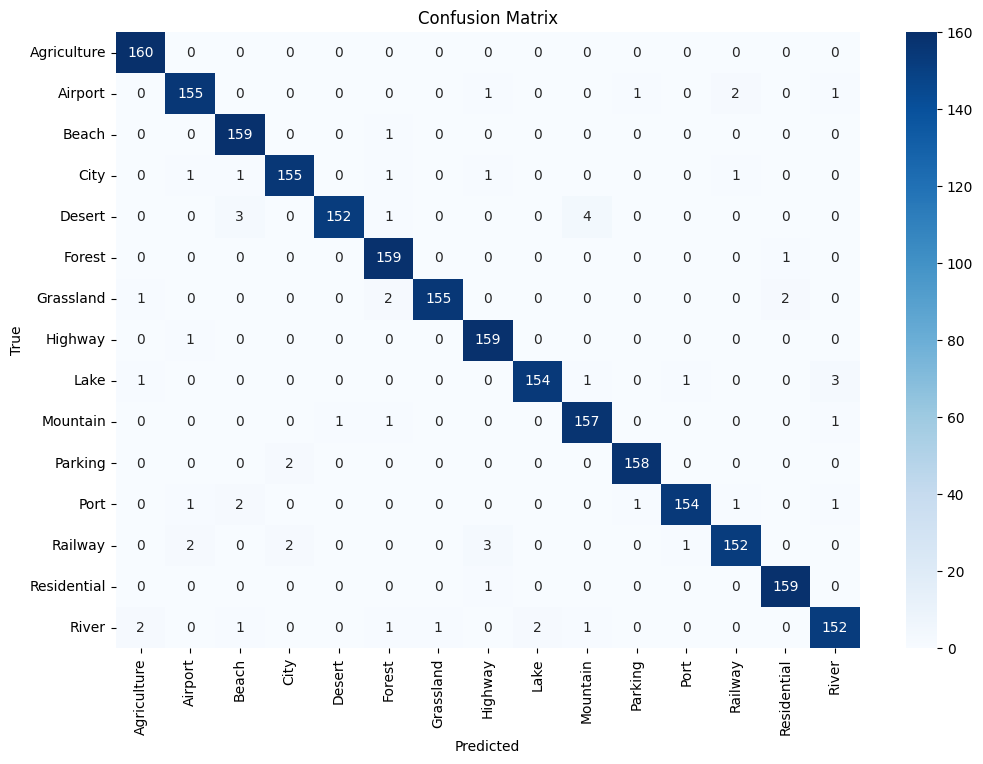

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = np.argmax(model.predict(test_data), axis=1)
y_true = np.argmax(y_test_enc, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



In [27]:
def display_predictions(images, true_labels, pred_labels, class_names, num_samples=5, title="Predictions"):
    fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(15, 3))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i])
            ax.set_title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}", fontsize=9)
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.75)  
    plt.show()


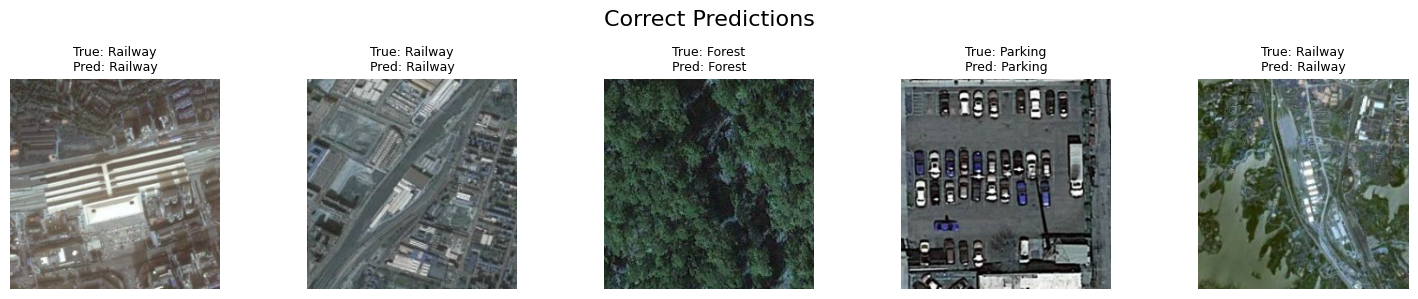

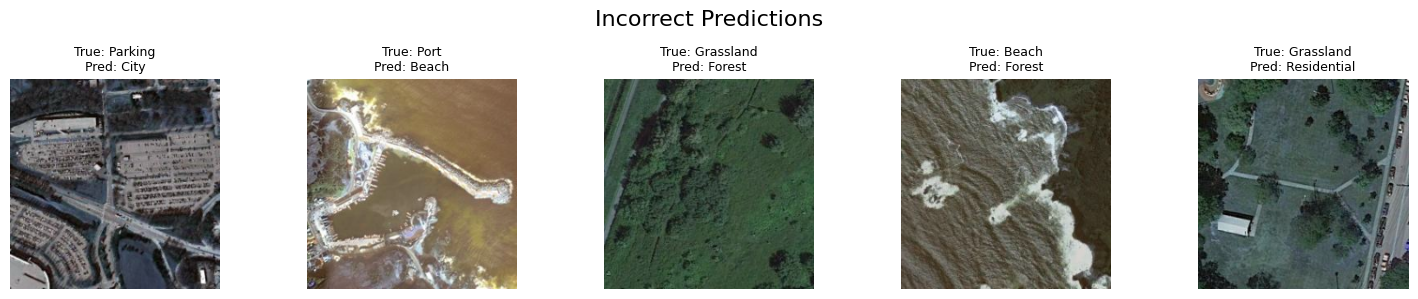

In [28]:
# Select the image index with the correct/incorrect prediction
correct_indices = np.where(y_true == y_pred)[0][:5]
incorrect_indices = np.where(y_true != y_pred)[0][:5]

# Display correct predictions
display_predictions(X_test[correct_indices], y_true[correct_indices], y_pred[correct_indices], class_names, num_samples=5, title="Correct Predictions")

# Display error prediction
display_predictions(X_test[incorrect_indices], y_true[incorrect_indices], y_pred[incorrect_indices], class_names, num_samples=5, title="Incorrect Predictions")
